In [1]:
import numpy as np
from sklearn import neighbors
from sklearn import metrics
import pandas as pd

# za normalizaciju
from sklearn import preprocessing

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline

# rad sa arff fajlovima
#import arff

# grafici
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# importujemo neighbors modul
from sklearn import neighbors

# 
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

# Cross validation attempts to avoid overfitting while still 
# producing a prediction for each observation dataset.
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

# Compute precision, recall, F-measure and support

# prognozirani pozitivni/negativni koji su zaista pozitivni od svih prognoziranih pozitivnih/negativnih 
# The precision is the ratio tp / (tp + fp) where tp is the number 
# of true positives and fp the number of false positives. 
# The precision is intuitively the ability of the classifier 
# to not label a sample as positive if it is negative

# odziv?
# => prognozirani pozitivni/negativni koji su zaista pozitivni od ukupno pozitivnih/negativnih
# The recall is the ratio tp / (tp + fn) where tp is the number 
# of true positives and fn the number of false negatives. 
# The recall is intuitively the ability of the classifier to find all the positive samples

# The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, 
# where an F-beta score reaches its best value at 1 and worst score at 0

# The F-beta score weights the recall more than the precision by a factor of beta. 
# beta = 1.0 means recall and precision are equally important

# svi koji pripadaju datoj klasi
# The support is the number of occurrences of each class in y_test

from sklearn.metrics import classification_report

# ROC Curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# oversampling
from imblearn.over_sampling import SMOTE

from collections import Counter

# feature selection
from sklearn.feature_selection import SelectPercentile, f_classif

In [2]:
from arff2pandas import a2p
    
with open('JM1.arff') as f:
    df = a2p.load(f)

print(df.shape)

(10878, 22)


In [3]:
# uklanjamo instance koje imaju nedostajuce vrednosti
df = df.dropna()
print(df.shape)

(10878, 22)


In [4]:
df = df.drop(columns = ['CYCLOMATIC_COMPLEXITY@NUMERIC', 'DESIGN_COMPLEXITY@NUMERIC', 'ESSENTIAL_COMPLEXITY@NUMERIC', 'BRANCH_COUNT@NUMERIC'])

In [5]:
df['Defective@{Y,N}'].value_counts()

N    8776
Y    2102
Name: Defective@{Y,N}, dtype: int64

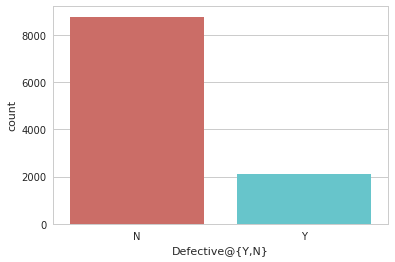

In [6]:
sns.countplot(x='Defective@{Y,N}', data=df, palette='hls')
plt.show()

In [7]:
# kodiramo Y/N u 1/0
df['Defective@{Y,N}'] = pd.factorize(df['Defective@{Y,N}'])[0]

In [8]:
# ciljna kolona(defects@{false, true})
y_cols=['Defective@{Y,N}']

# lista atributa
X_cols=[i for i in df.columns if i not in y_cols]

In [9]:
X=df[X_cols]
y=df[y_cols]

In [10]:
np.set_printoptions(suppress='True')

In [11]:
X = preprocessing.normalize(X)

In [12]:
y = y.values.ravel()

In [13]:
# pre oversampling-a

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [15]:
# try K=1 through K=25 and record testing accuracy
k_range = range(1, 26)

# We can create Python dictionary using [] or dict()
k_scores = []

# We use a loop through the range 1 to 26
# We append the scores in the dictionary
for k in k_range:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    k_scores.append(metrics.accuracy_score(y_test, y_pred))

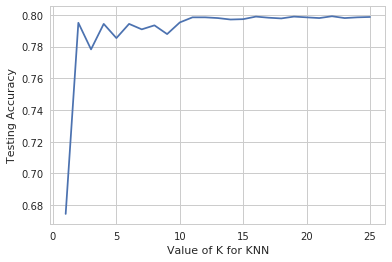

In [16]:
# plot the relationship between K and testing accuracy
# plt.plot(x_axis, y_axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
figname = 'KNN_basic_data_k_accuracy.png'
plt.savefig(figname)
plt.show()

In [17]:
knn = neighbors.KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, np.ravel(y_train))
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.7973345588235294


In [18]:
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = knn
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, np.ravel(y_train), cv=kfold, scoring=scoring)
print("10-fold cross validation: ")
print("average accuracy: %.9f" % (results.mean()))
print("standard deviation: %.9f" % (results.std()))

10-fold cross validation: 
average accuracy: 0.810907656
standard deviation: 0.015378028


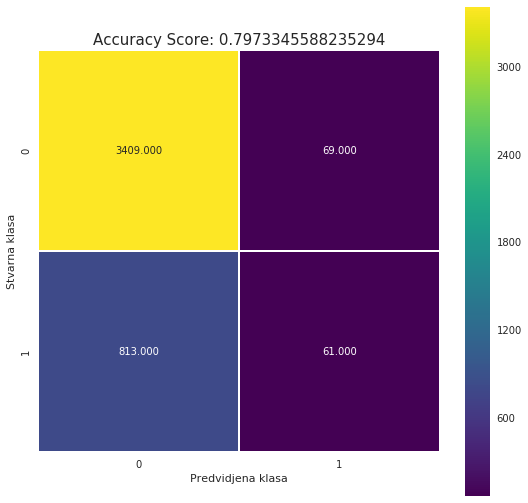

In [19]:
cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'viridis');
plt.ylabel('Stvarna klasa');
plt.xlabel('Predvidjena klasa');
all_sample_title = 'Accuracy Score: {0}'.format(metrics.accuracy_score(y_test, y_pred))
plt.title(all_sample_title, size = 15);
figname = 'KNN_basic_data_confussion_matrix.png'
plt.savefig(figname)
plt.show()

In [20]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.81      0.98      0.89      3478
          1       0.47      0.07      0.12       874

avg / total       0.74      0.80      0.73      4352



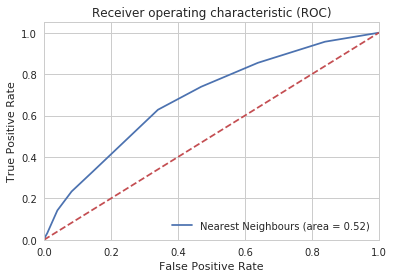

In [21]:
# The receiver operating characteristic (ROC) curve is 
# another common tool used with binary classifiers. 
# The dotted line represents the ROC curve of a purely 
# random classifier; a good classifier stays as far away 
# from that line as possible (toward the top-left corner)

logit_roc_auc = roc_auc_score(y_test, knn.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Nearest Neighbours (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
figname = 'KNN_basic_data_ROC.png'
plt.savefig(figname)
plt.show()

In [22]:
# oversampling

In [23]:
X_resampled, y_resampled = SMOTE().fit_sample(X, y)

In [24]:
print(sorted(Counter(y_resampled).items()))

[(0, 8776), (1, 8776)]


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=42)

In [26]:
# try K=1 through K=25 and record testing accuracy
k_range = range(1, 26)

# We can create Python dictionary using [] or dict()
k_scores = []

# We use a loop through the range 1 to 26
# We append the scores in the dictionary
for k in k_range:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    k_scores.append(metrics.accuracy_score(y_test, y_pred))

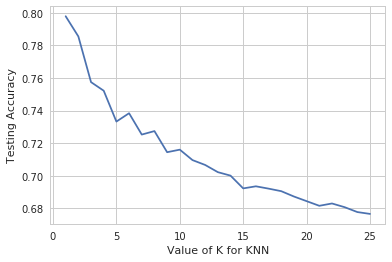

In [27]:
# plot the relationship between K and testing accuracy
# plt.plot(x_axis, y_axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
figname = 'KNN_oversampled_k_accuracy.png'
plt.savefig(figname)
plt.show()

In [28]:
knn = neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, np.ravel(y_train))
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.7574419598347814


In [29]:
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = knn
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, np.ravel(y_train), cv=kfold, scoring=scoring)
print("10-fold cross validation: ")
print("average accuracy: %.9f" % (results.mean()))
print("standard deviation: %.9f" % (results.std()))

10-fold cross validation: 
average accuracy: 0.744185583
standard deviation: 0.011049330


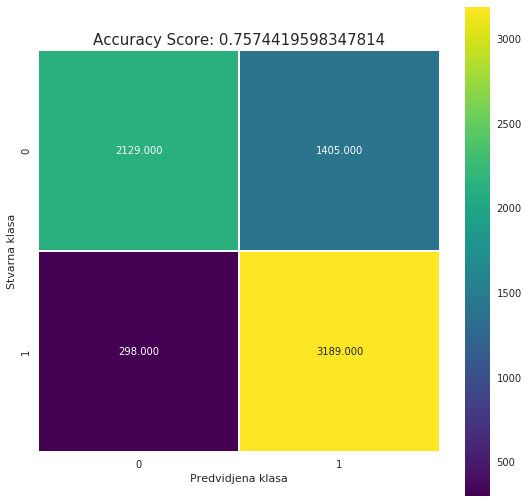

In [30]:
cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'viridis');
plt.ylabel('Stvarna klasa');
plt.xlabel('Predvidjena klasa');
all_sample_title = 'Accuracy Score: {0}'.format(metrics.accuracy_score(y_test, y_pred))
plt.title(all_sample_title, size = 15);
figname = 'KNN_oversampled_confussion_matrix.png'
plt.savefig(figname)
plt.show()

In [31]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.88      0.60      0.71      3534
          1       0.69      0.91      0.79      3487

avg / total       0.79      0.76      0.75      7021



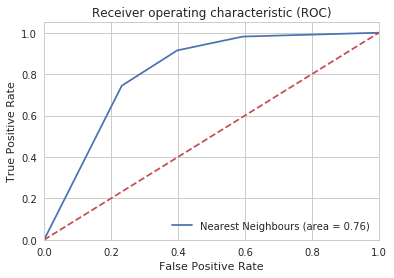

In [32]:
logit_roc_auc = roc_auc_score(y_test, knn.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Nearest Neighbours (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
figname = 'KNN_oversampled_ROC.png'
plt.savefig(figname)
plt.show()

In [33]:
# izbor atributa

In [34]:
X_indices = np.arange(X.shape[-1])

In [35]:
# Univariate feature selection with F-test for feature scoring
# We use the default selection function: the 10% most significant features
selector = SelectPercentile(f_classif, percentile=60)
selector.fit(X, y)
X_transformed = selector.transform(X)

In [36]:
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

<BarContainer object of 17 artists>

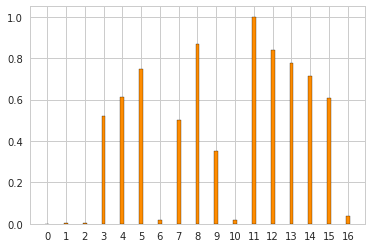

In [37]:
plt.xticks(np.arange(0, len(X_indices)+1, 1.0))
plt.bar(X_indices , scores, width=.2, label=r'Univariate score ($-Log(p_{value})$)', color='darkorange',
        edgecolor='black')

In [38]:
ind = np.argpartition(scores, -10)[-10:]
print(df.columns[ind])

Index(['HALSTEAD_ERROR_EST@NUMERIC', 'LOC_EXECUTABLE@NUMERIC',
       'NUM_UNIQUE_OPERATORS@NUMERIC', 'HALSTEAD_DIFFICULTY@NUMERIC',
       'HALSTEAD_CONTENT@NUMERIC', 'NUM_OPERANDS@NUMERIC',
       'NUM_OPERATORS@NUMERIC', 'NUM_UNIQUE_OPERANDS@NUMERIC',
       'HALSTEAD_LENGTH@NUMERIC', 'HALSTEAD_VOLUME@NUMERIC'],
      dtype='object')


In [39]:
# posle izbora atributa a pre oversampling-a

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.4, random_state=42)

In [41]:
# try K=1 through K=25 and record testing accuracy
k_range = range(1, 26)

# We can create Python dictionary using [] or dict()
k_scores = []

# We use a loop through the range 1 to 26
# We append the scores in the dictionary
for k in k_range:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    k_scores.append(metrics.accuracy_score(y_test, y_pred))

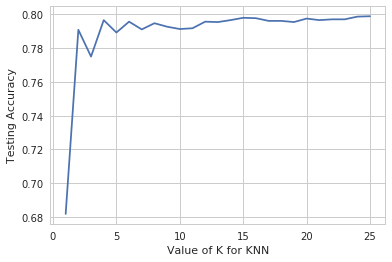

In [42]:
# plot the relationship between K and testing accuracy
# plt.plot(x_axis, y_axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
figname = 'KNN_feature_selection_k_accuracy.png'
plt.savefig(figname)
plt.show()

In [43]:
knn = neighbors.KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, np.ravel(y_train))
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.7980238970588235


In [44]:
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = knn
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, np.ravel(y_train), cv=kfold, scoring=scoring)
print("10-fold cross validation: ")
print("average accuracy: %.9f" % (results.mean()))
print("standard deviation: %.9f" % (results.std()))

10-fold cross validation: 
average accuracy: 0.810600438
standard deviation: 0.014970639


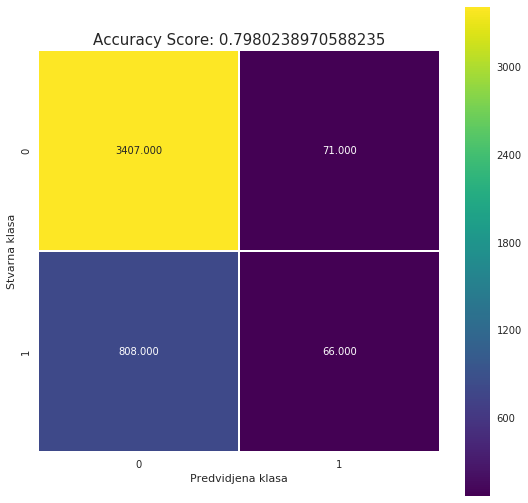

In [45]:
cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'viridis');
plt.ylabel('Stvarna klasa');
plt.xlabel('Predvidjena klasa');
all_sample_title = 'Accuracy Score: {0}'.format(metrics.accuracy_score(y_test, y_pred))
plt.title(all_sample_title, size = 15);
figname = 'KNN_feature_selection_confussion_matrix.png'
plt.savefig(figname)
plt.show()

In [46]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.81      0.98      0.89      3478
          1       0.48      0.08      0.13       874

avg / total       0.74      0.80      0.73      4352



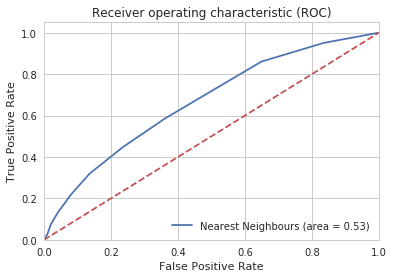

In [47]:
logit_roc_auc = roc_auc_score(y_test, knn.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Nearest Neighbours (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
figname = 'KNN_feature_selection_ROC.png'
plt.savefig(figname)
plt.show()

In [48]:
# posle izbora atributa i oversampling-a 

In [49]:
X_resampled, y_resampled = SMOTE().fit_sample(X_transformed, y)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=42)

In [51]:
# try K=1 through K=25 and record testing accuracy
k_range = range(1, 26)

# We can create Python dictionary using [] or dict()
k_scores = []

# We use a loop through the range 1 to 26
# We append the scores in the dictionary
for k in k_range:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    k_scores.append(metrics.accuracy_score(y_test, y_pred))

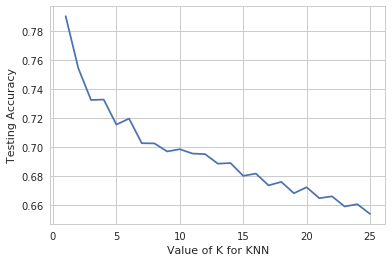

In [52]:
# plot the relationship between K and testing accuracy
# plt.plot(x_axis, y_axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
figname = 'KNN_feature_selection_oversampled_k_accuracy.png'
plt.savefig(figname)
plt.show()

In [53]:
knn = neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, np.ravel(y_train))
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.7325167355077624


In [54]:
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = knn
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, np.ravel(y_train), cv=kfold, scoring=scoring)
print("10-fold cross validation: ")
print("average accuracy: %.9f" % (results.mean()))
print("standard deviation: %.9f" % (results.std()))

10-fold cross validation: 
average accuracy: 0.745705052
standard deviation: 0.016454322


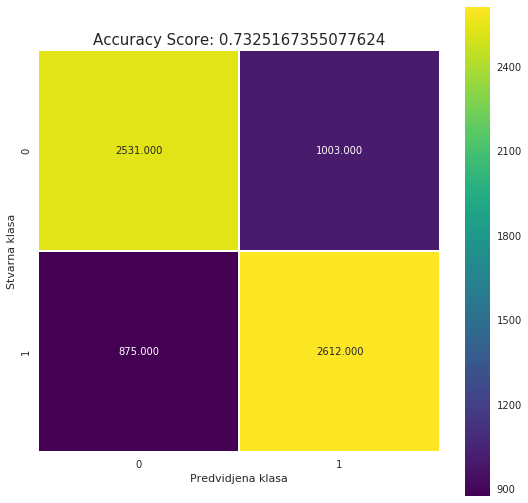

In [55]:
cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'viridis');
plt.ylabel('Stvarna klasa');
plt.xlabel('Predvidjena klasa');
all_sample_title = 'Accuracy Score: {0}'.format(metrics.accuracy_score(y_test, y_pred))
plt.title(all_sample_title, size = 15);
figname = 'KNN_feature_selection_oversampled_confussion_matrix.png'
plt.savefig(figname)
plt.show()

In [56]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.74      0.72      0.73      3534
          1       0.72      0.75      0.74      3487

avg / total       0.73      0.73      0.73      7021



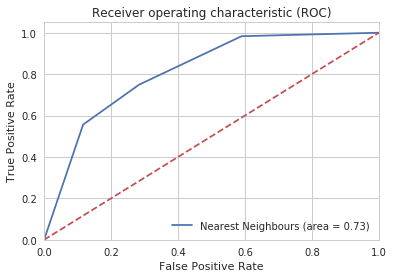

In [57]:
logit_roc_auc = roc_auc_score(y_test, knn.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Nearest Neighbours (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
figname = 'KNN_feature_selectionoversampled_ROC.png'
plt.savefig(figname)
plt.show()